In [1]:
import os
os.chdir(".")

from model import CNN_Model, LSTM_Model_RUL, CNN_Model_RUL, Net, Net_new, Autoencoder, LSTM_Model
from load_data import get_data, get_data_RUL_scenario1, get_discharge_capacities, get_dirs, NormalizeData, get_data_RUL_scenario2
from dataloader import battery_dataloader, battery_dataloader_RUL, get_RUL_dataloader
from import_file import *
from train_model import train_model, train_model_RUL, test_model_RUL, perform_n_folds
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from util_FPC import get_fpc_window, get_data, get_fpc, get_change_indices, EarlyStopping, plot_RUL, weight_reset

In [2]:
get_dirs()
discharge_capacities = get_discharge_capacities()

In [3]:
np.array(discharge_capacities[0]).shape

(7, 1851)

In [4]:
percentage  = 0.10  # 10 percent data
window_size = 50    # window size
stride = 1          # stride
channels  =[0,1,2,3,4,5,6] # channels
name_start_train = 0
name_start_test = 100


train_data,FPC_data,FPC_data_dict = get_data(discharge_capacities[:name_start_test],percentage,window_size,stride,channels,type = "train", name_start=name_start_train)
test_data,test_data_dict  = get_data(discharge_capacities[name_start_test:],None,window_size,stride,channels,type= "test", name_start=name_start_test)

obj_train  = battery_dataloader(train_data)
obj_FPC  = battery_dataloader(FPC_data)
obj_test  = battery_dataloader(test_data)


train_dataloader = DataLoader(obj_train, batch_size=8,shuffle=True)
FPC_dataloader   = DataLoader(obj_FPC,batch_size=1,shuffle=False)
test_dataloader = DataLoader(obj_test, batch_size=1,shuffle=False)


In [5]:
print("Number of Channels  :", channels)
print("Shape of a batch    :",next(iter(train_dataloader))[0].shape)

Number of Channels  : [0, 1, 2, 3, 4, 5, 6]
Shape of a batch    : torch.Size([8, 7, 50])


In [8]:
epochs = 4
window_size = 50
learning_rate = 0.001

pretrained = True
load_pretrained = False
version = 2

ch = ''.join(map(str,channels))

# model = CNN_Model(window_size,len(channels))
model = LSTM_Model(window_size,len(channels))

model_dir = "./Weights/FPC/"
model_path = f'{model_dir}/model_f{ch}_f{window_size}_f{model.name}_f{version}.pth'

if(load_pretrained):
    model.load_state_dict(torch.load(model_path, map_location=device ))

model.to(device)


optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, betas= (0.9, 0.99))
criterion = nn.BCELoss()

early_stopping = EarlyStopping(patience=20)


if(pretrained):
    
    model.load_state_dict(torch.load(model_path, map_location=device ))
    model.to(device)
else:
    model = train_model(model, optimizer, criterion, early_stopping,train_dataloader,epochs,learning_rate,load_pretrained,model_path,version)

version = 2
# Get Change Indices
change_indices_train,change_indices_test, _, _ = get_change_indices(model,discharge_capacities,channels,get_saved_indices = True, version = 2, name_start_train = name_start_train,name_start_test= name_start_test , dataset= "MIT") 
change_indices_all = np.concatenate((change_indices_train,change_indices_test))

Loading Old Indices
Mean FPC for Training is 96.29052875890393and Test is 97.17881069260905


<Figure size 432x288 with 0 Axes>

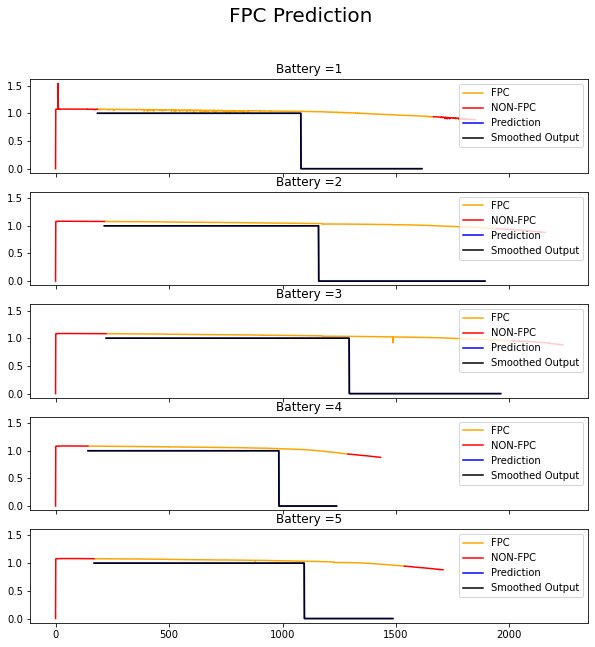

In [9]:
batteries = [i for i in range(0,5)]
_,_ = get_fpc(model,batteries,discharge_capacities,FPC_data_dict,True, True,True,"Outputs/FPC_Training")

<Figure size 432x288 with 0 Axes>

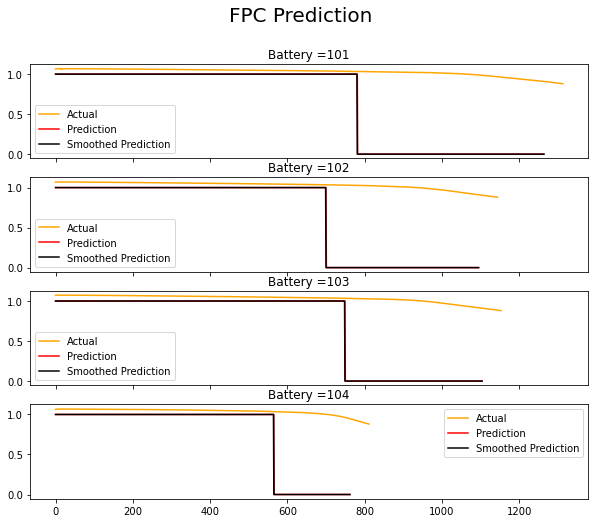

In [10]:
batteries = [i+100 for i in range(0,4)]
_,_ = get_fpc(model,batteries,discharge_capacities,test_data_dict,True, False,False,"Outputs/FPC_Testing")

In [11]:
# Model Testing
# transformer_model = Net()
# out,d = transformer_model(torch.rand((5,7,50)))

In [12]:
channels_RUL = [0,1,2,3,4,5,6]
window_size_RUL = 50
stride_RUL =1
c_RUL = ''.join(map(str,channels_RUL))


In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [15]:
n_folds = 5
scenario = 1
# learning_rate = 0.01
learning_rate = 0.0001
epochs = 2

parameters = {
    "window_size" : window_size,
    "stride": stride,
    "channels": channels_RUL,
    "epochs": epochs,
    "learning_rate": learning_rate
}



# model_RUL = LSTM_Model_RUL(window_size,len(channels))  # LSTM Model
model_RUL = Net(len(channels))    # Transformer Model
#model_RUL = CNN_Model_RUL(window_size,channels)    # CNN Model

optimizer = torch.optim.Adam(model_RUL.parameters(), lr = learning_rate, betas= (0.9, 0.99))
# criterion = nn.L1Loss()
criterion = nn.MSELoss()
early_stopping = EarlyStopping(patience=50)

version = 1
pretrained_RUL_scenario1 = False
load_pretrained_scenario1  = False

model_dir_scenario1 = "./Weights/Scenario1/"
model_path_scenario1 = f'{model_dir_scenario1}/model_f{model_RUL.name}_f{c_RUL}_f{window_size_RUL}_f{version}.pth'

if(pretrained_RUL_scenario1):
    print("Loading a Pre-trained Model")
    model_RUL.load_state_dict(torch.load(model_path_scenario1,map_location= device))
    test_batteries = np.load("./Test_data/test_batteries.npy",allow_pickle=True)
    train_batteries = np.load("./Test_data/train_batteries.npy",allow_pickle=True)
else:
    if(load_pretrained_scenario1):
        print("Training further on already trained model")
        model_RUL.load_state_dict(torch.load(model_path_scenario1,map_location= device))
        perform_n_folds(model_RUL,n_folds,discharge_capacities,change_indices_all,criterion, optimizer, early_stopping,
                    pretrained_RUL_scenario1, model_path_scenario1,scenario,parameters, version)
    else:
        model_RUL, test_dataloader, test_batteries, train_batteries = perform_n_folds(model_RUL,n_folds,discharge_capacities,change_indices_all,criterion, optimizer, early_stopping,
                    pretrained_RUL_scenario1, model_path_scenario1,scenario,parameters, version)
        np.save(f"./Test_data/test_batteries.npy", test_batteries, allow_pickle=True)
        np.save(f"./Test_data/train_batteries.npy", train_batteries, allow_pickle=True)

*********************  Fold = 0  ********************* 


Epoch = 0, Loss = 0.10324435292392488 
Epoch = 1, Loss = 0.05502441699413674 

 Average Time per Epoch : 3.5515655279159546


Test loss = 0.055043065085952886 


*********************  Fold = 1  ********************* 


Epoch = 0, Loss = 0.06621481764295338 
Epoch = 1, Loss = 0.06031894587837909 

 Average Time per Epoch : 3.6972182989120483


Test loss = 0.05451333708853683 


*********************  Fold = 2  ********************* 


Epoch = 0, Loss = 0.07056279464977006 
Epoch = 1, Loss = 0.06124449295027301 

 Average Time per Epoch : 4.206163287162781


Test loss = 0.050362115809883604 


*********************  Fold = 3  ********************* 


Epoch = 0, Loss = 0.06423781084407024 
Epoch = 1, Loss = 0.05683401655667144 

 Average Time per Epoch : 4.15140688419342


Test loss = 0.052541331076136344 


*********************  Fold = 4  ********************* 


Epoch = 0, Loss = 0.06656314135432642 
Epoch = 1, Loss = 0.0572340

In [16]:
# batteries =[0,1,2]
# plot_RUL(model_RUL_scenario2,discharge_capacities,batteries,train_dataloader_RUL_temp_scenario2,change_indices_train,"scenario2_RUL_prediction_train")


In [17]:
# test_batteries  = [i+100 for i in [16,17,18]]
# plot_RUL(model_RUL_scenario2,discharge_capacities,test_batteries,test_dataloader_RUL_scenario2,change_indices_test,"scenario2_RUL_prediction_test")

MSE= 0.041453540325164795, MAE =0.16575537621974945 , MAPE = 0.4317622184753418


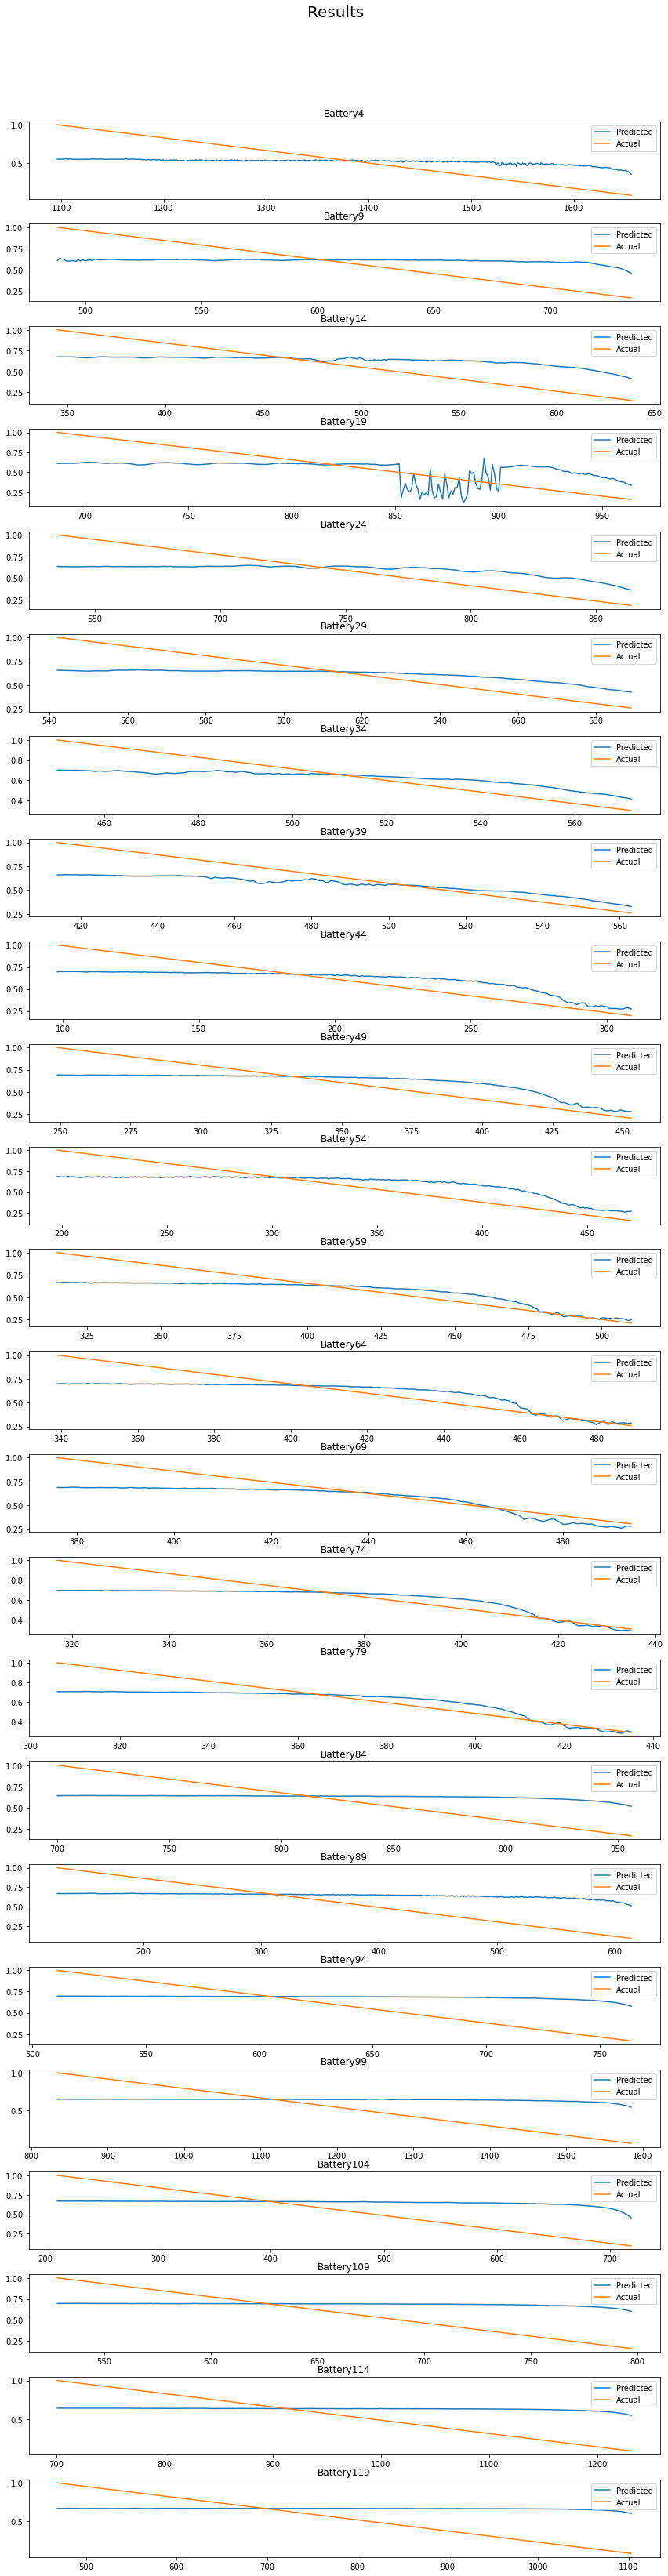

In [18]:
# test_batteries  = [i+100 for i in range(24)]
_, _, test_dataloader_RUL = get_RUL_dataloader(discharge_capacities, train_batteries, test_batteries, 
                                              change_indices_all, parameters["window_size"],
                                              parameters["stride"],parameters["channels"] ,scenario)

plot_RUL(model_RUL,discharge_capacities,test_batteries,test_dataloader,change_indices_all,"Outputs/scenario1_RUL_prediction_test")

In [ ]:
# batteries =[0,1,2,3]
# plot_RUL(model_RUL_scenario1,discharge_capacities,batteries,train_dataloader_RUL_temp_scenario1,change_indices_train,"scenario1_RUL_prediction_train")